In [1]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

import flopy as flopy
import pyemu
import shapefile #the pyshp module
from pyemu.pst.pst_utils import SFMT,IFMT,FFMT,pst_config

flopy is installed in C:\Users\seonggyu.park\Miniconda3\envs\sm_pest\lib\site-packages\flopy


# <span style="color:blue">1. Set up pilot points network for the white model some</span>.

There are multiple approaches to implementing pilot points with PEST++.  

In this class, we will use some kick-ass pyemu sweetness

### 1.1. Set up zones for where pilot points will be interpolated

We can have pilot point networks in multiple zones. In this case, we will make a simple zone file using `IBOUND` such that all active cells are in the same interpolation zone.

In [2]:
working_dir = 'D:\\Projects\\Watersheds\\White\\Analysis\\APEX-MODFLOWs\\calibration\\white_apexmf_110420\\APEX-MODFLOW\\MODFLOW'
mname = "wt_1500.nam"
os.chdir(working_dir)




In [5]:
# m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=wd,load_only=[]) #<-- load only prevents reading ibound
m = flopy.modflow.Modflow.load(
            mname,
            model_ws=working_dir
            )
m.check()

AssertionError: Util2d.load() error: open/close file D:\Projects\Watersheds\White\Analysis\APEX-MODFLOWs\calibration\white_apexmf_110420\APEX-MODFLOW\MODFLOW\MODFLOW\hk0pp.dat.ref not found

In [4]:
m.bas6.ibound[0].plot()

NameError: name 'm' is not defined

### 1.2. It is for when pilot points don't exist. We don't want pilot points or care about HK values in inactive cells, but we do need values in constant heads

We are going to use a pyemu helper function to setup pilot points are cell centers for active cells.

In [101]:
# Create pilot points as a shapefile
# we want hk pilot points in the top layer...
prefix_dict = {0:["sy0"]}
df_pp_hk = pyemu.pp_utils.setup_pilotpoints_grid(ml=m,
                                              prefix_dict=prefix_dict,
                                              pp_dir=working_dir,
                                              tpl_dir=working_dir,
                                              every_n_cell=10,
                                              shapename='pp_sy.shp')
# pp_file = os.path.join(working_dir,"sypp.dat")
# assert os.path.exists(pp_file)


### 1.3. Create dataframe from shapefile

#### **1.3.1. Change Shapefile name**

In [150]:
# change shapefile and file name
shpwd = working_dir
shp = 'pp_hk.shp'
shp_changed = 'hk0pp.shp'
ppf = shp_changed[:-3] + 'dat'
ppf

'hk0pp.dat'

#### **1.3.2. Shapefile to Dataframe**

In [151]:
#read file, parse out the records and shapes
shapefile_path = os.path.join(shpwd, shp)
sf = shapefile.Reader(shapefile_path)

#grab the shapefile's field names (omit the first psuedo field)
fields = [x[0] for x in sf.fields][1:]
records = sf.records()
shps = [s.points for s in sf.shapes()]

#write the records into a dataframe
shapefile_dataframe = pd.DataFrame(columns=fields, data=records)

#add the coordinate data to a column called "coords"
shapefile_dataframe = shapefile_dataframe.assign(coords=shps)

pp_df = shapefile_dataframe.sort_values(by=['name'])
print(pp_df)

       name         x        y  zone  parval1  k   i    j              tpl  \
0   pp_0000   68250.0  96750.0   1.0      1.0  0   5   45  ~    hk000    ~   
1   pp_0001   83250.0  96750.0   1.0      1.0  0   5   55  ~    hk001    ~   
2   pp_0002   53250.0  81750.0   1.0      1.0  0  15   35  ~    hk002    ~   
3   pp_0003   68250.0  81750.0   1.0      1.0  0  15   45  ~    hk003    ~   
4   pp_0004   83250.0  81750.0   1.0      1.0  0  15   55  ~    hk004    ~   
5   pp_0005   98250.0  81750.0   1.0      1.0  0  15   65  ~    hk005    ~   
6   pp_0006  113250.0  81750.0   1.0      1.0  0  15   75  ~    hk006    ~   
7   pp_0007   38250.0  66750.0   1.0      1.0  0  25   25  ~    hk007    ~   
8   pp_0008   53250.0  66750.0   1.0      1.0  0  25   35  ~    hk008    ~   
9   pp_0009   68250.0  66750.0   1.0      1.0  0  25   45  ~    hk009    ~   
10  pp_0010   83250.0  66750.0   1.0      1.0  0  25   55  ~    hk010    ~   
11  pp_0011   98250.0  66750.0   1.0      1.0  0  25   65  ~    

In [152]:
os.chdir(working_dir)

In [153]:
os.getcwd()

'D:\\Projects\\Watersheds\\White\\Analysis\\APEX-MODFLOWs\\calibration\\white_apexmf_110420\\APEX-MODFLOW\\MODFLOW'

In [154]:
pyemu.utils.pp_utils.write_pp_file(ppf, pp_df)
# pyemu.utils.pp_utils.pilot_points_to_tpl('hahaha.dat')

In [155]:
PP_FMT = {"name": SFMT, "x": FFMT, "y": FFMT, "zone": IFMT, "tpl": SFMT,
          "parval1": FFMT}
def pp_to_tpl(pp_file, tpl_file=None):
    names = pp_df['parnme'].tolist() # for hk
    # names = pp_df['sypar'].tolist() # for sy  
#     names = pp_df['parnme'].tolist() # for river conductance      
    if tpl_file is None:
        tpl_file = pp_file + ".tpl"    
    tpl_entries = ["~    {0}    ~".format(name) for name in names]
    pp_df.loc[:,"tpl"] = tpl_entries
    pp_df.loc[:,"parnme"] = names


    f_tpl = open(tpl_file,'w')
    f_tpl.write("ptf ~\n")
    f_tpl.write(pp_df.to_string(col_space=0,
                              columns=["name","x","y","zone","tpl"],
                              formatters=PP_FMT,
                              justify="left",
                              header=False,
                              index=False) + '\n')    
pp_to_tpl(ppf)

Let's look at ``pp_df`` - it has a lot of useful info

In [156]:
pp_df

,name,x,y,zone,parval1,k,i,j,tpl,parnme,...,pp_filenam,pargp,partrans,parchglim,parlbnd,parubnd,scale,offset,dercom,coords
0,pp_0000,68250.0,96750.0,1.0,1.0,0,5,45,~ hk000 ~,hk000,...,D:\Projects\Watersheds\White\Analysis\APEX-MODFLOW,hk0,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1,"[[-1072550.0124365697, 1999998.037659365]]"
1,pp_0001,83250.0,96750.0,1.0,1.0,0,5,55,~ hk001 ~,hk001,...,D:\Projects\Watersheds\White\Analysis\APEX-MODFLOW,hk0,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1,"[[-1057550.0124365697, 1999998.037659365]]"
2,pp_0002,53250.0,81750.0,1.0,1.0,0,15,35,~ hk002 ~,hk002,...,D:\Projects\Watersheds\White\Analysis\APEX-MODFLOW,hk0,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1,"[[-1087550.0124365697, 1984998.037659365]]"
3,pp_0003,68250.0,81750.0,1.0,1.0,0,15,45,~ hk003 ~,hk003,...,D:\Projects\Watersheds\White\Analysis\APEX-MODFLOW,hk0,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1,"[[-1072550.0124365697, 1984998.037659365]]"
4,pp_0004,83250.0,81750.0,1.0,1.0,0,15,55,~ hk004 ~,hk004,...,D:\Projects\Watersheds\White\Analysis\APEX-MODFLOW,hk0,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1,"[[-1057550.0124365697, 1984998.037659365]]"
5,pp_0005,98250.0,81750.0,1.0,1.0,0,15,65,~ hk005 ~,hk005,...,D:\Projects\Watersheds\White\Analysis\APEX-MODFLOW,hk0,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1,"[[-1042550.0124365697, 1984998.037659365]]"
6,pp_0006,113250.0,81750.0,1.0,1.0,0,15,75,~ hk006 ~,hk006,...,D:\Projects\Watersheds\White\Analysis\APEX-MODFLOW,hk0,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1,"[[-1027550.0124365697, 1984998.037659365]]"
7,pp_0007,38250.0,66750.0,1.0,1.0,0,25,25,~ hk007 ~,hk007,...,D:\Projects\Watersheds\White\Analysis\APEX-MODFLOW,hk0,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1,"[[-1102550.0124365697, 1969998.037659365]]"
8,pp_0008,53250.0,66750.0,1.0,1.0,0,25,35,~ hk008 ~,hk008,...,D:\Projects\Watersheds\White\Analysis\APEX-MODFLOW,hk0,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1,"[[-1087550.0124365697, 1969998.037659365]]"
9,pp_0009,68250.0,66750.0,1.0,1.0,0,25,45,~ hk009 ~,hk009,...,D:\Projects\Watersheds\White\Analysis\APEX-MODFLOW,hk0,log,factor,1.000000e-10,1.100000e+10,1.0,0.0,1,"[[-1072550.0124365697, 1969998.037659365]]"


So cool, we now defined pilot points as a set of spatially distributed parameters...but how do go from pilot points to the model input HK array? Answer: geostatistics.  We need to calculate the geostatistical factors (weights) used to form the interpolated value for the HK value at each model cell - its a spatially-weighted combination of pilot point values

# <span style="color:blue">2. Geostatistics</span>

## Need to create Kriging factors and regularization inputs
Following the guidelines in _Approaches to Highly Parameterized Inversion: Pilot-Point Theory, Guidelines, and Research Directions_ https://pubs.usgs.gov/sir/2010/5168/

### First we need to define a couple geostatistical structures (e.g. variograms)

From _PEST Groundwater Data Utilities Part A: Overview_ page 43, there are 4 acceptable variogram types:

 1. *Spherical*  
### $\gamma\left(h\right)=c\times\left[1.5\frac{h}{a}-0.5\frac{h}{a}^3\right]$ if $h<a$
### $\gamma\left(h\right)=c$ if $h \ge a$  
     
 2. *Exponential*  
### $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h}{a}\right)\right]$  
     
 3. *Gaussian*  
### $\gamma\left(h\right)=c\times\left[1-\exp\left(-\frac{h^2}{a^2}\right)\right]$  
 
 4. *Power*  
### $\gamma\left(h\right)=c\times h^a$
     
 The number refers to `VARTYPE`. `BEARING` and `ANISOTROPY` only apply if there is a principal direction of anisotropy. $h$ is the separation distance, and $a$ is the range, expressed with the `A` parameter.


### First, let's create ``variogram`` and ``GeoStruct`` objects.  

These describe how HK varies spatailly, remember?

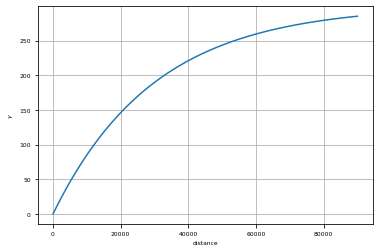

In [157]:
v = pyemu.geostats.ExpVario(contribution=300,a=30000, bearing=0)
gs = pyemu.geostats.GeoStruct(variograms=v,nugget=0.0)
ax = gs.plot()
ax.grid()
# ax.set_ylim(0,2.0)

Now, let's get an ``OrdinaryKrige`` object, which needs the ``GeoStruct`` as well as the x, y, and name of the pilot point locations (which happens to be in that really cool ``df_pp`` instance)

In [158]:
ok = pyemu.geostats.OrdinaryKrige(gs,pp_df)

Once the ``OrdinaryKrige`` is created, we need to calculate the geostatistical interpolation factors for each model cell.  We do this with the ``.calc_factors_grid()`` method: it needs to know about the model's spatial orientation and also accepts some optional arguments:

### Kriging Processing... it takes time

In [159]:
df = ok.calc_factors_grid(m.sr,
#                           var_filename=pst_name.replace(".pst",".var.ref"),
                          var_filename= ppf[:-3] + "var.ref",                          
                          minpts_interp=1,maxpts_interp=50,
                          search_radius=1000000000000.0)


starting interp point loop for 9170 points
took 38.017214 seconds


One of the really cool things about geostatistics is that it gives you both the interpolation (factors), but also gives you the uncertainty in the areas between control (pilot) points.  Above, we wrote this uncertainty information to an array that has the same rows and cols as the model grid - this array is very useful for understanding the function of the variogram.

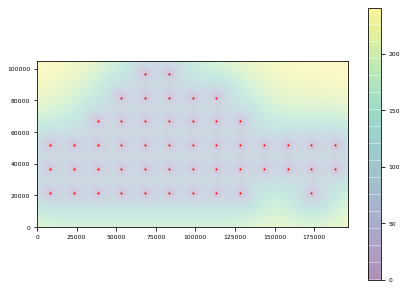

In [160]:
# arr_var = np.loadtxt(pst_name.replace(".pst",".var.ref"))
arr_var = np.loadtxt(ppf[:-3] + "var.ref")
ax = plt.subplot(111,aspect="equal")
p = ax.imshow(arr_var,extent=m.sr.get_extent(),alpha=0.25)
plt.colorbar(p)
plt.tight_layout()
ax.scatter(pp_df.x,pp_df.y,marker='.',s=4,color='r')

We see that at the pilot point locations (red dots), the uncertainty in the geostats is minimal...as expected. The call to ``.calc_factors_grid()`` also returns a ``DataFrame`` which has useful info - lets look:

In [161]:
df

,x,y,idist,inames,ifacts,err_var
0,750.0,104250.0,"[53033.00858899106, 53033.00858899106, 57118.298293979315, 57118.298293979315, 64517.4395028197,...","[pp_0014, pp_0007, pp_0002, pp_0015, pp_0016, pp_0008, pp_0000, pp_0027, pp_0003, pp_0028, pp_00...","[0.1711173521763919, 0.12362584246572338, 0.10855925845301061, 0.04185010658880373, -0.008784309...",237.056942
1,2250.0,104250.0,"[51983.17035349037, 52841.74486142561, 55742.71252818614, 56544.23047491229, 63302.84353802758, ...","[pp_0007, pp_0014, pp_0002, pp_0015, pp_0008, pp_0016, pp_0000, pp_0027, pp_0003, pp_0028, pp_00...","[0.12745947115846326, 0.1695380525495413, 0.11296903520117971, 0.04281724152948189, -0.012539791...",236.467774
2,3750.0,104250.0,"[50955.863254389085, 52692.504210750885, 54373.706881175574, 56004.46410778341, 62100.7246334533...","[pp_0007, pp_0014, pp_0002, pp_0015, pp_0008, pp_0016, pp_0000, pp_0027, pp_0003, pp_0028, pp_00...","[0.1313188084142957, 0.16766014799940263, 0.11764381894852623, 0.04370419985165291, -0.013032455...",235.844545
3,5250.0,104250.0,"[49952.477416040136, 52585.644428874315, 53011.791141216876, 55500.0, 60911.821512740855, 62010....","[pp_0007, pp_0014, pp_0002, pp_0015, pp_0008, pp_0016, pp_0000, pp_0003, pp_0027, pp_0028, pp_00...","[0.13518058213231693, 0.1654856521964445, 0.12259594970098445, 0.04449723890009559, -0.013523303...",235.183845
4,6750.0,104250.0,"[48974.483151943525, 51657.52607316769, 52521.42420003479, 55031.80898353242, 59736.92325521963,...","[pp_0007, pp_0002, pp_0014, pp_0015, pp_0008, pp_0016, pp_0000, pp_0003, pp_0027, pp_0028, pp_00...","[0.13901808271595983, 0.12783755056613916, 0.16301923562978987, 0.04518272785524035, -0.01401025...",234.481928
...,...,...,...,...,...,...
9165,189750.0,750.0,"[26706.740722147282, 36031.23644839294, 39601.136347332256, 47835.65615730592, 51022.05405508484...","[pp_0049, pp_0039, pp_0038, pp_0037, pp_0026, pp_0025, pp_0036, pp_0024, pp_0048, pp_0023, pp_00...","[0.3975097915375511, 0.17908021105208377, -0.03536797030154369, -0.005045391610431755, 0.0382180...",204.844580
9166,191250.0,750.0,"[27658.633371878663, 36124.783736376885, 40249.22359499621, 48836.46178829912, 51088.1590977792,...","[pp_0049, pp_0039, pp_0038, pp_0037, pp_0026, pp_0025, pp_0036, pp_0024, pp_0048, pp_0023, pp_00...","[0.3828088139077142, 0.1861787785268699, -0.03497911033073283, -0.006002509506110658, 0.04028154...",207.009190
9167,192750.0,750.0,"[28657.4597618142, 36280.15986734347, 40942.032191868544, 49862.310415783984, 51198.14449762804,...","[pp_0049, pp_0039, pp_0038, pp_0037, pp_0026, pp_0025, pp_0036, pp_0024, pp_0048, pp_0023, pp_00...","[0.36810799322182797, 0.1925075150803458, -0.034650148677648214, -0.006736078670192445, 0.042471...",209.141525
9168,194250.0,750.0,"[29698.484809834998, 36496.57518178932, 41677.33196834941, 50911.68824543142, 51351.72830587107,...","[pp_0049, pp_0039, pp_0038, pp_0037, pp_0026, pp_0025, pp_0036, pp_0024, pp_0048, pp_0023, pp_00...","[0.35354909288878256, 0.19802761777296263, -0.03437633662846295, -0.007275025549206388, 0.044771...",211.226609


We see that there is one row for each model cell, and for each row, we see the distance, names, and weight for the "nearby" pilot points.  The interpolated value for cells that have a pilot point at their center only need one weight - 1.0 - and one pilot point.  Other cells are weighted combinations of pilot points.  Is this clear?  

### Now we need to save the factors (weights) to a special file that we will use later to quickly generate a new HK array from a set of pilot point values:

In [162]:
ok.to_grid_factors_file(ppf+".fac")

Just for demo purposes, lets generate ``random`` pilot point values and run them through the factors to see what the ``hk`` array looks like

In [163]:
# generate random values
pp_df.loc[:,"parval1"] = np.random.random(pp_df.shape[0])
# save a pilot points file
pyemu.pp_utils.write_pp_file(ppf,pp_df)

In [164]:
# interpolate the pilot point values to the grid
hk_arr = pyemu.utils.geostats.fac2real(ppf,factors_file=ppf+".fac",out_file=None)

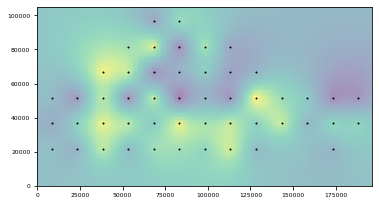

In [165]:
# plot
ax = plt.subplot(111,aspect='equal')
ax.imshow(hk_arr,interpolation="nearest",extent=m.sr.get_extent(),alpha=0.5)
ax.scatter(pp_df.x,pp_df.y,marker='.',s=4,color='k')

What happens if you recalculate the factors using one point for every cell? Change ``max_interp_pts`` to 1 in the ``calc_factors_grid()`` and rerun these cells...

### An aside on geostatistics and covariance matrices

The ``GeoStruct`` object above was used to interpolate from pilot point locations to each node in the grid.  But this same ``GoeStruct`` also has an important information regarding how the pilot points are related to each other spatially---that is, the ``GeoStruct`` object implies a covariance matrix.  Let's form that matrix 

In [117]:
cov = gs.covariance_matrix(pp_df.x,pp_df.y,pp_df.parnme)

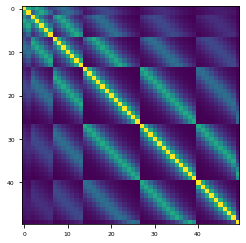

In [60]:
plt.imshow(cov.x)

In [61]:
cov.to_dataframe()

,hk000,hk001,hk002,hk003,hk004,hk005,hk006,hk007,hk008,hk009,...,hk040,hk041,hk042,hk043,hk044,hk045,hk046,hk047,hk048,hk049
hk000,300.000000,181.959198,147.920607,181.959198,147.920607,98.076569,61.722198,72.935020,98.076569,110.363832,...,12.209573,16.253472,20.311761,23.435986,24.625500,23.435986,20.311761,16.253472,12.209573,4.065838
hk001,181.959198,300.000000,98.076569,147.920607,181.959198,147.920607,98.076569,49.452214,72.935020,98.076569,...,8.742958,12.209573,16.253472,20.311761,23.435986,24.625500,23.435986,20.311761,16.253472,6.041532
hk002,147.920607,98.076569,300.000000,181.959198,110.363832,66.939048,40.600585,147.920607,181.959198,147.920607,...,24.625500,32.063378,38.176863,40.600585,38.176863,32.063378,24.625500,17.731724,12.209573,3.426867
hk003,181.959198,147.920607,181.959198,300.000000,181.959198,110.363832,66.939048,98.076569,147.920607,181.959198,...,17.731724,24.625500,32.063378,38.176863,40.600585,38.176863,32.063378,24.625500,17.731724,5.326283
hk004,147.920607,181.959198,110.363832,181.959198,300.000000,181.959198,110.363832,61.722198,98.076569,147.920607,...,12.209573,17.731724,24.625500,32.063378,38.176863,40.600585,38.176863,32.063378,24.625500,8.151738
hk005,98.076569,147.920607,66.939048,110.363832,181.959198,300.000000,181.959198,38.176863,61.722198,98.076569,...,8.151738,12.209573,17.731724,24.625500,32.063378,38.176863,40.600585,38.176863,32.063378,12.209573
hk006,61.722198,98.076569,40.600585,66.939048,110.363832,181.959198,300.000000,23.435986,38.176863,61.722198,...,5.326283,8.151738,12.209573,17.731724,24.625500,32.063378,38.176863,40.600585,38.176863,17.731724
hk007,72.935020,49.452214,147.920607,98.076569,61.722198,38.176863,23.435986,300.000000,181.959198,110.363832,...,49.452214,61.722198,66.939048,61.722198,49.452214,35.961975,24.625500,16.253472,10.482220,2.612652
hk008,98.076569,72.935020,181.959198,147.920607,98.076569,61.722198,38.176863,181.959198,300.000000,181.959198,...,35.961975,49.452214,61.722198,66.939048,61.722198,49.452214,35.961975,24.625500,16.253472,4.186146
hk009,110.363832,98.076569,147.920607,181.959198,147.920607,98.076569,61.722198,110.363832,181.959198,300.000000,...,24.625500,35.961975,49.452214,61.722198,66.939048,61.722198,49.452214,35.961975,24.625500,6.658511


What do these numbers mean?  Why should you care?  Well, this covariance matrix plays an important role in uncertainty quantification, as well as in governing the way pilot point parameters are adjusted during calibration

# Build instruction files (Streamflow / Watertable)

### 1. Streamflow (output.rch)

In [178]:
from apexmf_pst_pkgs import apexmf_pst_utils, apexmf_pst_par

In [186]:
working_dir = 'D:/Projects/Watersheds/White/Analysis/APEX-MODFLOWs/calibration/white_apexmf_110420/APEX-MODFLOW'
os.chdir(working_dir)
wd = 'D:/Projects/Watersheds/White/Analysis/APEX-MODFLOWs/calibration/white_apexmf_110420/APEX-MODFLOW/MODFLOW'



In [72]:
# Create parm template file

sw_par = apexmf_pst_utils.parm_to_tpl_file()
sw_par

,0,1,2,3,4,5,6,7,8,9
0,1.50,2.,.5,0.9000,~p5 ~,0.500,0.990,20.000,20.000,20.000
1,-100.00,~p12 ~,2.0000,1.,~p15 ~,~p16 ~,~p17 ~,1.500,0.003,~p20 ~
2,10.00,0.90,~p23 ~,0.1000,~p25 ~,0.000,0.300,5.000,.01,1.100
3,0.30,1.00,2.5000,0.,0.9900,0.,0.200,1.000,.01,~p40 ~
4,0.50,0.40,0.1500,2.0000,3.0000,0.500,1.000,0.000,~p49 ~,~p50 ~
5,~p51 ~,10.00,0.9000,0.6000,0.2000,0.900,1.000,0.600,0.100,7.000
6,~p61 ~,0.25,1.1000,1.0000,0.0010,3.000,10.000,0.500,0.500,1.
7,1.15,.05,0.5000,0.2000,0.8000,.05,0.000,10.000,1.000,.5
8,0.00,3.,0.5100,0.0001,0.0001,0.010,0.010,0.001,0.100,~p90 ~
9,~p91 ~,~p92 ~,1.,1.,7.,1.,.9,1.,1.,.000548


### 1.1.1 Create river parameters


In [181]:
# provide channel ids that will be used for calibration
subs = ['g066', 'g074', 'g102']
apexmf_pst_par.create_riv_par(wd, subs)

'mf_riv.par' file has been exported to the SWAT-MODFLOW working directory!


,parnme,chg_type,val
parnme,,,
rivcd_g066,rivcd_g066,unfchg,0.001
rivcd_g074,rivcd_g074,unfchg,0.001
rivcd_g102,rivcd_g102,unfchg,0.001
rivbot_g066,rivbot_g066,unfchg,0.001
rivbot_g074,rivbot_g074,unfchg,0.001
rivbot_g102,rivbot_g102,unfchg,0.001


In [183]:
# create a template file for mf_riv.par file
apexmf_pst_utils.riv_par_to_template_file('mf_riv.par')

,parnme,chg_type,parval1,tpl
parnme,,,,
rivcd_g066,rivcd_g066,pctchg,0.001,~ rivcd_g066 ~
rivcd_g074,rivcd_g074,pctchg,0.001,~ rivcd_g074 ~
rivcd_g102,rivcd_g102,pctchg,0.001,~ rivcd_g102 ~
rivbot_g066,rivbot_g066,unfchg,0.001,~ rivbot_g066 ~
rivbot_g074,rivbot_g074,unfchg,0.001,~ rivbot_g074 ~
rivbot_g102,rivbot_g102,unfchg,0.001,~ rivbot_g102 ~


In [184]:
# overwrite the river package file
apexmf_pst_par.riv_par(wd)

The original river package "wt_1500.riv" has been backed up...
wt_1500.riv file is overwritten successfully!


# 1.2. Build instruction files (streamflow / watertable / baseflow)
## 1.2.1. Streamflow (output.rch)

In [221]:
# file path
rch_file = 'SITE66.RCH'
# reach numbers that are used for calibration
subs = [66, 102, 133]
# extract month_streamflow
apexmf_pst_utils.extract_month_str(rch_file, subs, '1/1/2000', '1/1/2010', '12/31/2014')

cha_066.txt file has been created...
cha_102.txt file has been created...
cha_133.txt file has been created...
Finished ...


### 1.2.3. Create instruction files for each str_sim file using the 'streamflow.obd' file

In [222]:
# because we have 3 streamgages let's loop for them
# read streamobd and get column names
stf_obd = pd.read_csv(
                    'streamflow_month.obd',
                    sep='\t',
                    index_col=0,
                    parse_dates=True,
                    na_values=[-999, '']
                    )
# stf_obd_c = stf_obd.resample('M').mean()
# stf_obd_c.to_csv('streamflow_m.obd', sep='\t', na_rep=-999, float_format='%.2f')
obds = stf_obd.columns.tolist()
obds.remove('sub046')
obds.remove('sub130')
print(obds)
sim_files = ['cha_{:03d}.txt'.format(x) for x in subs]
# sed_files = ['sed_{:03d}.txt'.format(x) for x in subs]
# sim_files = sim_files + sed_files
print(sim_files)

['sub066', 'sub102', 'sub133']
['cha_066.txt', 'cha_102.txt', 'cha_133.txt']


In [238]:
# create instruction files for each sim file
for i in range(len(sim_files)):
    apexmf_pst_utils.stf_obd_to_ins(sim_files[i], obds[i], '1/1/2010', '12/31/2014', time_step='month')

cha_066.txt.ins file has been created...
cha_102.txt.ins file has been created...
cha_133.txt.ins file has been created...


In [239]:
# We do have watertable data now
grid_ids = [4912, 5959]
apexmf_pst_utils.extract_watertable_sim(grid_ids, '1/1/2000', '12/31/2014')

wt_4912.txt file has been created...
wt_5959.txt file has been created...
Finished ...


In [240]:
apexmf_pst_utils.mf_obd_to_ins('wt_4912.txt', 'g492', '1/1/2010', '12/31/2014')

wt_4912.txt.ins file has been created...


date
2000-01-01                      l1
2000-01-02                      l1
2000-01-03                      l1
2000-01-04                      l1
2000-01-05                      l1
                      ...         
2014-12-27    l1 w !g492_20141227!
2014-12-28    l1 w !g492_20141228!
2014-12-29    l1 w !g492_20141229!
2014-12-30    l1 w !g492_20141230!
2014-12-31    l1 w !g492_20141231!
Freq: D, Name: g492_ins, Length: 5479, dtype: object

In [241]:
io_files = pyemu.helpers.parse_dir_for_io_files('.')
pst = pyemu.Pst.from_io_files(*io_files)
pyemu.helpers.pst_from_io_files(io_files[0], io_files[1], io_files[2], io_files[3], 'white_dummy.pst')

# print(os.chdir(".."))
io_files

error using inschek for instruction file cha_066.txt.ins:run() returned non-zero: 1
observations in this instruction file will havegeneric values.
error using inschek for instruction file cha_102.txt.ins:run() returned non-zero: 1
observations in this instruction file will havegeneric values.
error using inschek for instruction file cha_133.txt.ins:run() returned non-zero: 1
observations in this instruction file will havegeneric values.
error using inschek for instruction file wt_4912.txt.ins:run() returned non-zero: 1
observations in this instruction file will havegeneric values.
error using inschek for instruction file wt_5959.txt.ins:run() returned non-zero: 1
observations in this instruction file will havegeneric values.
error using inschek for instruction file cha_066.txt.ins:run() returned non-zero: 1
observations in this instruction file will havegeneric values.
error using inschek for instruction file cha_102.txt.ins:run() returned non-zero: 1
observations in this instruction f

(['hk0pp.dat.tpl', 'mf_riv.par.tpl', 'PARM1501.DAT.tpl', 'sy0pp.dat.tpl'],
 ['hk0pp.dat', 'mf_riv.par', 'PARM1501.DAT', 'sy0pp.dat'],
 ['cha_066.txt.ins',
  'cha_102.txt.ins',
  'cha_133.txt.ins',
  'wt_4912.txt.ins',
  'wt_5959.txt.ins'],
 ['cha_066.txt', 'cha_102.txt', 'cha_133.txt', 'wt_4912.txt', 'wt_5959.txt'])

The ``parse_dir_for_io_files()`` helper is looking for files with the ".tpl" and ".ins" extension.  This assumes that the corresponding model input and model output files are the same name, minus the ".tpl" and ".ins" extension, respectively.  These file lists are then passed to another helper, which builds a basic control file for you (``Pst.from_io_files()``).  Let's look at this generic ``Pst`` instance:

In [242]:
par = pst.parameter_data
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
hk000,hk000,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk001,hk001,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk002,hk002,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk003,hk003,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
hk004,hk004,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
sy045,sy045,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
sy046,sy046,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
sy047,sy047,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
sy048,sy048,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1


## 2.1. Change parameter group name

In [243]:
for i in range(len(par)):
    if (par.iloc[i, 0][:2]) == 'sy':
        par.iloc[i, 6] = 'sy'
    elif par.iloc[i, 0][:7] == 'rivbot_':
        par.iloc[i, 6] = 'rivbot'
    elif par.iloc[i, 0][:6] == 'rivcd_':
        par.iloc[i, 6] = 'rivcd'
    elif par.iloc[i, 0][:2] == 'hk':
        par.iloc[i, 6] = 'hk'
    elif par.iloc[i, 0][:1] == 'p':
        par.iloc[i, 6] = 'apex'
    # else:
    #     par.iloc[i, 6] = 'str'
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
hk000,hk000,log,factor,1.0,1.100000e-10,1.100000e+10,hk,1.0,0.0,1
hk001,hk001,log,factor,1.0,1.100000e-10,1.100000e+10,hk,1.0,0.0,1
hk002,hk002,log,factor,1.0,1.100000e-10,1.100000e+10,hk,1.0,0.0,1
hk003,hk003,log,factor,1.0,1.100000e-10,1.100000e+10,hk,1.0,0.0,1
hk004,hk004,log,factor,1.0,1.100000e-10,1.100000e+10,hk,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
sy045,sy045,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1
sy046,sy046,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1
sy047,sy047,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1
sy048,sy048,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1


In [244]:
par = par.sort_values(by=['pargp', 'parnme'])
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
p12,p12,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
p15,p15,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
p16,p16,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
p17,p17,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
p20,p20,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
sy045,sy045,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1
sy046,sy046,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1
sy047,sy047,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1
sy048,sy048,log,factor,1.0,1.100000e-10,1.100000e+10,sy,1.0,0.0,1


### 3. Set par ranges and values for MODFLOW

In [245]:
# for MODFLOW parameters
for i in range(len(par)):
    if (par.iloc[i, 6]) == 'hk':
        par.iloc[i, 4] = 1.100000e-03
        par.iloc[i, 5] = 1.100000e+03
    elif par.iloc[i, 6] == 'sy':
        par.iloc[i, 3] = 0.100000e+00 
        par.iloc[i, 4] = 1.000000e-03
        par.iloc[i, 5] = 0.700000e+00        
    elif par.iloc[i, 6] == 'rivcd':
        par.iloc[i, 3] = 50.01   # initial    
        par.iloc[i, 4] = 0.1   # lower
        par.iloc[i, 5] = 100   # upper
        par.iloc[i, 8] = -50   # offset
    elif par.iloc[i, 6] == 'rivbot':
        par.iloc[i, 3] = 5.0001   # initial    
        par.iloc[i, 4] = 0.1   # lower
        par.iloc[i, 5] = 10   # upper
        par.iloc[i, 8] = -5   # offset
#     else:
#         par.iloc[i, 6] = 'str_par'


In [231]:
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
p12,p12,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
p15,p15,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
p16,p16,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
p17,p17,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
p20,p20,log,factor,1.0,1.100000e-10,1.100000e+10,apex,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
sy045,sy045,log,factor,0.1,1.000000e-03,7.000000e-01,sy,1.0,0.0,1
sy046,sy046,log,factor,0.1,1.000000e-03,7.000000e-01,sy,1.0,0.0,1
sy047,sy047,log,factor,0.1,1.000000e-03,7.000000e-01,sy,1.0,0.0,1
sy048,sy048,log,factor,0.1,1.000000e-03,7.000000e-01,sy,1.0,0.0,1


# APEX

In [246]:
pst.parameter_data = apexmf_pst_utils.export_pardb_pest(par)

In [247]:
par = pst.parameter_data
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
p12,p12,log,factor,2.50000,1.50000,2.5,apex,1.0,0.0,1
p15,p15,log,factor,0.00001,0.00001,0.3,apex,1.0,0.0,1
p16,p16,log,factor,1.00000,1.00000,1.5,apex,1.0,0.0,1
p17,p17,log,factor,0.25000,0.00001,0.5,apex,1.0,0.0,1
p20,p20,log,factor,0.20000,0.05000,0.4,apex,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
sy045,sy045,log,factor,0.10000,0.00100,0.7,sy,1.0,0.0,1
sy046,sy046,log,factor,0.10000,0.00100,0.7,sy,1.0,0.0,1
sy047,sy047,log,factor,0.10000,0.00100,0.7,sy,1.0,0.0,1
sy048,sy048,log,factor,0.10000,0.00100,0.7,sy,1.0,0.0,1



Cool - the other tpl files were found and parsed - parameter listed in them were added to the control file.  But we have generic entries for initial values bounds...

## Observation

In [248]:
obd = pst.observation_data
print(obd)

                      obsnme        obsval  weight  obgnme
g492_20100622  g492_20100622  1.000000e+10     1.0  obgnme
g492_20100623  g492_20100623  1.000000e+10     1.0  obgnme
g492_20100624  g492_20100624  1.000000e+10     1.0  obgnme
g492_20100625  g492_20100625  1.000000e+10     1.0  obgnme
g492_20100626  g492_20100626  1.000000e+10     1.0  obgnme
...                      ...           ...     ...     ...
sub133_201408  sub133_201408  1.000000e+10     1.0  obgnme
sub133_201409  sub133_201409  1.000000e+10     1.0  obgnme
sub133_201410  sub133_201410  1.000000e+10     1.0  obgnme
sub133_201411  sub133_201411  1.000000e+10     1.0  obgnme
sub133_201412  sub133_201412  1.000000e+10     1.0  obgnme

[3118 rows x 4 columns]


In [272]:
for i in range(len(obd)):
    if obd.iloc[i, 0][:6] == 'sub066':
        obd.iloc[i, 3] = 'sub066'
    elif obd.iloc[i, 0][:6] == 'sub133':
        obd.iloc[i, 3] = 'sub133'
    elif obd.iloc[i, 0][:6] == 'sub102':
        obd.iloc[i, 3] = 'sub102'
    elif obd.iloc[i, 0][:4] == 'g492':
        obd.iloc[i, 3] = 'g492'
    elif obd.iloc[i, 0][:4] == 'g593':
        obd.iloc[i, 3] = 'g593'


In [273]:
print(obd)

                      obsnme        obsval  weight  obgnme
g492_20100622  g492_20100622  1.000000e+10     1.0    g492
g492_20100623  g492_20100623  1.000000e+10     1.0    g492
g492_20100624  g492_20100624  1.000000e+10     1.0    g492
g492_20100625  g492_20100625  1.000000e+10     1.0    g492
g492_20100626  g492_20100626  1.000000e+10     1.0    g492
...                      ...           ...     ...     ...
sub133_201408  sub133_201408  1.000000e+10     1.0  sub133
sub133_201409  sub133_201409  1.000000e+10     1.0  sub133
sub133_201410  sub133_201410  1.000000e+10     1.0  sub133
sub133_201411  sub133_201411  1.000000e+10     1.0  sub133
sub133_201412  sub133_201412  1.000000e+10     1.0  sub133

[3118 rows x 4 columns]


## 2.3. Import measured data

In [274]:
gwt_obd = pd.read_csv('MODFLOW/modflow.obd',
                       sep='\t',
                       index_col = 0,
                       parse_dates = True,
                       na_values=[-999, '']
                     )
gwt_obd = gwt_obd['6/22/2010': '12/31/2014']
gwt_obd = gwt_obd[['g593', 'g492']]
gwt_obd

,g593,g492
date,,
2010-06-22,-18.60,-85.51
2010-06-23,-18.62,-85.53
2010-06-24,-18.60,-85.53
2010-06-25,-18.59,-85.53
2010-06-26,-18.59,-85.53
...,...,...
2014-12-27,-18.14,-87.15
2014-12-28,-18.11,-87.12
2014-12-29,-18.10,-87.11


In [275]:
stf_obd = pd.read_csv('streamflow_month.obd',
                       sep='\t',
                       index_col = 0,
                       parse_dates = True,
                       na_values=[-999, '']
                     )
stf_obd = stf_obd['1/1/2010': '12/31/2014']
stf_obd = stf_obd.drop(['sub046', 'sub130'], axis=1)
stf_obd

,sub066,sub102,sub133
date,,,
2010-01-31,8.42,8.40,8.24
2010-02-28,10.17,8.22,8.27
2010-03-31,13.77,8.72,8.28
2010-04-30,20.50,16.25,15.00
2010-05-31,33.62,36.01,33.31
2010-06-30,47.62,44.99,40.50
2010-07-31,11.06,11.75,10.11
2010-08-31,10.66,9.69,7.63
2010-09-30,5.73,5.80,3.46


In [276]:
# Get sub list based on obd order
sub_order = []
for i in obd.obgnme.tolist():
    if i not in sub_order:
        sub_order.append(i)
sub_order


['g492', 'g593', 'sub066', 'sub102', 'sub133']

In [277]:
# get total list from each sub obd, delete na vals
tot_obd = []
for i in sub_order[:2]:
    tot_obd += gwt_obd[i].dropna().tolist()
for j in sub_order[2:]:
    tot_obd += stf_obd[j].dropna().tolist()    
len(tot_obd)
# tot_obd

3118

In [278]:
obd.loc[:, 'obsval'] = tot_obd
obd

,obsnme,obsval,weight,obgnme
g492_20100622,g492_20100622,-85.51,1.0,g492
g492_20100623,g492_20100623,-85.53,1.0,g492
g492_20100624,g492_20100624,-85.53,1.0,g492
g492_20100625,g492_20100625,-85.53,1.0,g492
g492_20100626,g492_20100626,-85.53,1.0,g492
...,...,...,...,...
sub133_201408,sub133_201408,11.34,1.0,sub133
sub133_201409,sub133_201409,10.19,1.0,sub133
sub133_201410,sub133_201410,11.74,1.0,sub133
sub133_201411,sub133_201411,10.78,1.0,sub133


### 4. Export control file

In [280]:
pst.control_data.noptmax=0
pst.model_command = 'python forward_run.py'
pst.write('white_pest.pst')

noptmax:0, npar_adj:122, nnz_obs:3118


also cool - the instruction files in the directory were also found and parsed so that observation listed in the instruction files were added as well. There are some subtlies here, but we will skip them for now.

## Regularization

Regularization is ....

in pyemu, we can add two forms of regularization:
- preferred value: we want the parameter values to stay as close to the initial values as possible
- preferred difference: we prefer the differences in parameter values to be minimized

Preferred value is easy to understand, we simply add ``prior_information`` to the control file to enforce this condition.  pyemu uses a helper for this:

In [36]:
# load the pre-constructed pst
pst = pyemu.Pst(os.path.join(working_dir,pst_name))

In [37]:
pyemu.helpers.zero_order_tikhonov(pst,parbounds=False)

In [38]:
pst.prior_information

,pilbl,equation,obgnme,weight
0,hk00,1.0 * log(hk00) = 6.989700E-01,regulhk,1.0
1,hk01,1.0 * log(hk01) = 6.989700E-01,regulhk,1.0
2,hk02,1.0 * log(hk02) = 6.989700E-01,regulhk,1.0
3,hk03,1.0 * log(hk03) = 6.989700E-01,regulhk,1.0
4,hk04,1.0 * log(hk04) = 6.989700E-01,regulhk,1.0
5,hk05,1.0 * log(hk05) = 6.989700E-01,regulhk,1.0
6,hk06,1.0 * log(hk06) = 6.989700E-01,regulhk,1.0
7,hk07,1.0 * log(hk07) = 6.989700E-01,regulhk,1.0
8,hk08,1.0 * log(hk08) = 6.989700E-01,regulhk,1.0
9,hk09,1.0 * log(hk09) = 6.989700E-01,regulhk,1.0


Ok, that's fine, but should the weight on preferring HK not to change be the same as preferring recharge not to change?  Seems like we would want recharge to change less than HK.  This preference can be expressed by using the parameter bounds to form the weights

In [43]:
pyemu.helpers.zero_order_tikhonov(pst,parbounds=True)

In [44]:
pst.prior_information

,pilbl,equation,obgnme,weight
pilbl,,,,
hk00,hk00,1.0 * log(hk00) = 6.989700E-01,regulhk,0.500000
hk01,hk01,1.0 * log(hk01) = 6.989700E-01,regulhk,0.500000
hk02,hk02,1.0 * log(hk02) = 6.989700E-01,regulhk,0.500000
hk03,hk03,1.0 * log(hk03) = 6.989700E-01,regulhk,0.500000
hk04,hk04,1.0 * log(hk04) = 6.989700E-01,regulhk,0.500000
hk05,hk05,1.0 * log(hk05) = 6.989700E-01,regulhk,0.500000
hk06,hk06,1.0 * log(hk06) = 6.989700E-01,regulhk,0.500000
hk07,hk07,1.0 * log(hk07) = 6.989700E-01,regulhk,0.500000
hk08,hk08,1.0 * log(hk08) = 6.989700E-01,regulhk,0.500000


Now we are really preferring recharge not to change...good!

So what about preferred difference regularization?  Well pyemu can do that too.  Remember that ``Cov``ariance matrix we built above? It expresses the spatial relationship between pilot points, so we use to setup these prior information equations:

In [45]:
pyemu.helpers.first_order_pearson_tikhonov(pst,cov)

getting CC matrix


Exception: Matrix.indices(): name not found: porosity

In [46]:
pst.prior_information

,pilbl,equation,obgnme,weight
pilbl,,,,
hk00,hk00,1.0 * log(hk00) = 6.989700E-01,regulhk,0.500000
hk01,hk01,1.0 * log(hk01) = 6.989700E-01,regulhk,0.500000
hk02,hk02,1.0 * log(hk02) = 6.989700E-01,regulhk,0.500000
hk03,hk03,1.0 * log(hk03) = 6.989700E-01,regulhk,0.500000
hk04,hk04,1.0 * log(hk04) = 6.989700E-01,regulhk,0.500000
hk05,hk05,1.0 * log(hk05) = 6.989700E-01,regulhk,0.500000
hk06,hk06,1.0 * log(hk06) = 6.989700E-01,regulhk,0.500000
hk07,hk07,1.0 * log(hk07) = 6.989700E-01,regulhk,0.500000
hk08,hk08,1.0 * log(hk08) = 6.989700E-01,regulhk,0.500000


What happened?  We replace the preferred value equations with a bunch of new equations.  These equations each include two parameter names and have different weights - can you guess what the weights are?  The weights are the pearson correlation coefficients (CC) between the pilot points (remember those from way back?).  These CC values are calculated from the covariance matrix, which is implied by the geostatistical structure...whew! 

# For river Bed conductance interpolation

In [62]:
# interpolate the pilot point values to the grid
riv_cond = pyemu.gw_utils.fac2real(ppf,factors_file=ppf+".fac",out_file=None)

In [64]:
np.shape(riv_cond)

(154, 268)

## 1. get only river grids

In [139]:
df_riv = pd.read_csv(
                    shpwd + "\\mf\\ss_072519.riv",
                    delim_whitespace=True,
                    skiprows=3,
#                     usecols=[1,2],
                    header=None
                    )

In [136]:
new_riv_cf = [riv_cond[df_riv.iloc[i, 0], df_riv.iloc[i, 1]] for i in range(len(df_riv))]

In [137]:
df_riv.iloc[:, 4] = new_riv_cf
df_riv.iloc[:, 4] = df_riv.iloc[:, 4].map(lambda x: '{:.10e}'.format(x))
df_riv.iloc[:, 3] = df_riv.iloc[:, 3].map(lambda x: '{:.10e}'.format(x))
df_riv.iloc[:, 5] = df_riv.iloc[:, 5].map(lambda x: '{:.10e}'.format(x))

In [138]:
with open(os.path.join(shpwd + "\\mf", "ss_072519.riv"), 'w') as f:
    f.write("# RIV: River package file created on 7/25/2019 by ModelMuse version 4.0.0.0." + "\n")
    f.write("  1467     9 AUXILIARY IFACE # DataSet 2: MXACTC IRIVCB Option" + "\n")
    f.write("  1467     0 # Data Set 5: ITMP NP Stress period 1" + "\n")    
    df_riv.to_csv(f, sep='\t',
                  header=False,
                  index=False,
#                   float_format='%.2f', 
                  line_terminator='\n', 
                  encoding='utf-8')


# Build instruction files (Streamflow / Watertable)

### 1. Streamflow (channel_day.txt)

In [68]:
import csv

wd2 = "D:\\Projects\\MiddleBosque\\Analysis\\SWAT+MODFLOW Model_middle_bosque"
df_str = pd.read_csv(
                    wd2 + "\\channel_day - Copy.txt",
                    delim_whitespace=True,
                    skiprows=3,
#                     usecols=[1,2],
                    header=None
                    )
test = []
for i in range(len(df_str)):
    if df_str.iloc[i, 6] == 'cha53':
        a = 'l1 w w w w w w w w w '
        b = '!str_{}{:02d}{:02d}!'.format(df_str.iloc[i, 3], df_str.iloc[i, 1], df_str.iloc[i, 2])
        test.append(a+b)
    else:
        a = 'l1'
        test.append(a)


with open('str.ins', "w", newline='') as f:
    f.write("pif ~" + "\n")  
    writer = csv.writer(f)
    for row in test:
        writer.writerow([row])


### 2. Watertable (modflow_cell_obs.txt)

In [49]:
import csv
import pandas as pd
import numpy as np

st_date = '1/1/1980'
wd2 = "D:\\Projects\\MiddleBosque\\Analysis\\SWAT+MODFLOW Model_middle_bosque"
df_wt = pd.read_csv(
                    wd2 + "\\modflow_cell_obs.txt",
                    delim_whitespace=True,
                    skiprows=1,
#                     usecols=[1,2],
                    header=None
                    )
df_wt.index = pd.date_range(st_date, periods=len(df_wt))
# print(df_str)

co1L = []
co2D = []



# for i in range(len(df_str)):
#     if ((df_wt.index[i].strftime('%Y%m%d') >= '19850821') & (df_wt.index[i].strftime('%Y%m%d') <= '19860507')):
#         print('true')
df_wt['date'] = df_wt.index.strftime('%Y%m%d')
# df_wt['test'] = CO1L['8/21/1985':'5/7/1986']
# df_wt['test'] = df_wt[(df_wt.index >= '08/21/1985') & (df_wt.index <= '05/07/1986')] = 'w'
df_wt['2nd'] = np.where((df_wt.index >= '08/21/1985') & (df_wt.index <= '05/07/1986'), ('l1 !wt_2nd'+df_wt['date']+'!'), 'l1 w')
df_wt['1st'] = np.where((df_wt.index >= '09/30/1985') & (df_wt.index <= '04/01/1986'), ('!wt_1nd'+df_wt['date']+'!'), ' w')


print(df_wt)

with open('wt.ins', "w", newline='') as f:
    f.write("pif ~" + "\n")
    df_wt.to_csv(f, sep='\t',
                  header=False,
                  index=False,
#                   float_format='%.2f', 
                  line_terminator='\n', 
                  columns=('2nd','1st'),
                  encoding='utf-8')

'''
test = []
for i in range(len(df_str)):
    if df_str.iloc[i, 6] == 'cha53':
        a = 'l1 w w w w w w w w '
        b = '!str_{}{:02d}{:02d}!'.format(df_str.iloc[i, 3], df_str.iloc[i, 1], df_str.iloc[i, 2])
        test.append(a+b)
    else:
        a = 'l1'
        test.append(a)


with open('str.ins', "w", newline='') as f:
    f.write("pif ~" + "\n")  
    writer = csv.writer(f)
    for row in test:
        writer.writerow([row])
'''

                   0         1      date   2nd 1st
1980-01-01  255.5776  253.4422  19800101  l1 w   w
1980-01-02  255.6870  253.5240  19800102  l1 w   w
1980-01-03  255.7828  253.5971  19800103  l1 w   w
1980-01-04  255.8695  253.6645  19800104  l1 w   w
1980-01-05  255.9489  253.7285  19800105  l1 w   w
...              ...       ...       ...   ...  ..
2005-12-27  263.4627  261.2057  20051227  l1 w   w
2005-12-28  263.4421  261.1927  20051228  l1 w   w
2005-12-29  263.4519  261.1992  20051229  l1 w   w
2005-12-30  263.4284  261.1831  20051230  l1 w   w
2005-12-31  263.4290  261.1830  20051231  l1 w   w

[9497 rows x 5 columns]


'\ntest = []\nfor i in range(len(df_str)):\n    if df_str.iloc[i, 6] == \'cha53\':\n        a = \'l1 w w w w w w w w \'\n        b = \'!str_{}{:02d}{:02d}!\'.format(df_str.iloc[i, 3], df_str.iloc[i, 1], df_str.iloc[i, 2])\n        test.append(a+b)\n    else:\n        a = \'l1\'\n        test.append(a)\n\n\nwith open(\'str.ins\', "w", newline=\'\') as f:\n    f.write("pif ~" + "\n")  \n    writer = csv.writer(f)\n    for row in test:\n        writer.writerow([row])\n'

In [148]:
a = np.full((33, 55), 10)

In [149]:
np.shape(a)

(33, 55)

In [155]:
np.savetxt('test.txtt', a, fmt='%.12e', delimiter='\t')
np.savetxt('vtest.txtt', a/10, fmt='%.12e', delimiter='\t')

In [154]:
b = np.loadtxt('test.txtt')
b/10

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [111]:
with open('hk04.dat', 'r') as f:
    data = [x.strip().split() for x in f if x.strip()]
hk = float(data[0][4])
hk

1.0

In [120]:
data_fac = ['hk01.dat', 'hk02.dat', 'hk03.dat', 'sy01.dat', 'sy02.dat', 'sy03.dat']
for i in data_fac:
    if i[:2] == 'hk':
        print('true')



true
true
true


In [118]:
print(a)

hk01.dat.ref


In [119]:
b/10

TypeError: unsupported operand type(s) for /: 'str' and 'int'